# Motor efficiency and kinetic energy estimation using machine learning: A first approach.

In this work we use machine learning (ML) to predict values of the motor efficiency and kinetic energy part of the energy consumption of electric vehicles. The data used to train the data is a combination of previous results of minimized routes analyzed with our drive-data-analysis service, together with climate and vehicle characteristics data. 
Upon a through trial and fine tuning of several machine learning algorithms, we have set up a model consisting of a combination of a Random Forest and an Extra Trees regressors. 

After a careful evaluation of the final model and comparing its results with that of the current approach in which we use fixed mean values of the efficiency and kinetic energy parameters, we could quantify a reduction of the median absolute error of about 10.6% for the kinetic energy part at city speeds, 20.1% for highway speeds and of 25.1% for the motor efficiency. Since these parameters are important for the total energy consumption estimation of the vehicle in the routing algorithm, a reduction of their error estimation implies an increase in the accuracy of the consumption energy estimation and hence, in the quality of the routes calculated.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Missing-data." data-toc-modified-id="Missing-data.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Missing data.</a></span></li><li><span><a href="#Wrong/bad-data." data-toc-modified-id="Wrong/bad-data.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Wrong/bad data.</a></span></li><li><span><a href="#Adding-complementary-data." data-toc-modified-id="Adding-complementary-data.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Adding complementary data.</a></span></li></ul></li><li><span><a href="#ML-algorithm-selection" data-toc-modified-id="ML-algorithm-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ML algorithm selection</a></span><ul class="toc-item"><li><span><a href="#Strategy:" data-toc-modified-id="Strategy:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Strategy:</a></span><ul class="toc-item"><li><span><a href="#Train-Test-split" data-toc-modified-id="Train-Test-split-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Train-Test split</a></span></li><li><span><a href="#Algorithm-check." data-toc-modified-id="Algorithm-check.-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Algorithm check.</a></span><ul class="toc-item"><li><span><a href="#Direct-Multi-output-regression" data-toc-modified-id="Direct-Multi-output-regression-3.1.2.1"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>Direct Multi-output regression</a></span></li><li><span><a href="#Chained-multi-output-regression" data-toc-modified-id="Chained-multi-output-regression-3.1.2.2"><span class="toc-item-num">3.1.2.2&nbsp;&nbsp;</span>Chained multi-output regression</a></span></li></ul></li></ul></li><li><span><a href="#Hyperparameter-optimization" data-toc-modified-id="Hyperparameter-optimization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Hyperparameter optimization</a></span></li></ul></li><li><span><a href="#Is-there-any-improvement?" data-toc-modified-id="Is-there-any-improvement?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Is there any improvement?</a></span></li><li><span><a href="#Neural-Network:-(Addition-from-06.07.2021):" data-toc-modified-id="Neural-Network:-(Addition-from-06.07.2021):-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neural Network: (Addition from 06.07.2021):</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Introduction
The routing algorithm used in the eClever app is based on the exact determination of the energy consumption of the electric vehicle (EV) when its moves from point A to B. This energy consumption can be roughly subdivided into two main parts, a dynamic and a kinematic part. In the dynamic part we calculate all the energies that are exerted on the car on a given constant velocity such as air resistance, friction, potential energy, among others. The kinematic part, on the other hand, involves acceleration, a quantity which is difficult to estimate on a real scenario since it is dependent on parameters that can not be easily predefined such as transit conditions and the drivers drive style. A proper determination of the kinetic part of the energy consumption is of paramount importance in order to obtain a energy consumption estimation which is closest to a real case scenario. 

In a [previous work](https://eclever.atlassian.net/wiki/spaces/ROUTE/pages/1600913434/Kinetic+energy+and+battery+efficiency+determination+from+real+vehicle+data) we have tried to approach this problem by estimating the kinetic energy part of the energy consumption in terms of the dynamic part. This is done by calculating the energy consumption of a route from A to B and compare it to the real consumption as obtained from real drive data. We then minimize the difference of these two by the help of two parameters namely the motor efficiency ($eff$) and the kinetic energy portion ($f_{kin}$) of the energy consumption with the following model.
$$E_{tot} = \dfrac{E_i \cdot(1+f_{kin})}{eff}$$

The $f_{kin}$ parameter defines how much additional energy in terms of the dynamic energy we need to add to the initial calculation in order to obtain the real consumption. Thus, for example, after the minimization we get a $f_{kin}$ of 0.85 this means that in order to get the same consumption as the real data we need to add to the initially calculated energy $E_i$ (dynamic part) a value which is 85% of $E_i$.

Currently (06.07.2021) we use this approach in our *drive-data-analysis-service*. Here we perform a minimization process on a series of available drive data and estimate for all these trips the value of $f_{kin}$ and $eff$, then we subdivide the minimized routes into *city* and *highway* trips depending on their mean velocity and finally we calculate the mean $f_{kin}$ value for city and highway routes. These mean values are the ones we then use in the routing algorithm to try to compensate for the kinetic energy term we can not normally estimate.

The problem, however, is that the value of $f_{kin}$ has a large variance and a simple mean assumption is most likely very rough.

Therefore, we aim to go one step forward in the calculation of the energy consumption of a route by improving the estimation of the $f_{kin}$ and $eff$ parameters with the help of machine learning. The idea is that we we can predict the values of these parameters based of previously minimized ones. In this way, instead of adopting a fixed mean value, the machine learning model should *predict* a pair of $f_{kin}$ and $eff$ parameters based on values that it has learned from past routes that have been minimized.

## Data preparation

The data that we will use to train our machine learning model consists basically on the results of the minimization procedure we perform during the *drive-data-analysis-service*, together with some data of the minimized route. The basis data consists on the following columns:

+ **plugConfigurationInternalId**: Unique vehicle identifier.
+ **soc_ini**: State of Charge at the beginning of the route.
+ **speed**: Mean route speed.
+ **distance total**: Total distance of the route.
+ **date**: Date of the route. However the idea will be not to use the data itself but information such calendar week, day of the week and hour. Such information is important since transit conditions are dependent on such things like rush hours or if the trip takes place on a weekend. Moreover, information like calender week entails also seasonal weather information (winter/summer).
+ **battery_temp_ini**: Battery temperature of the vehicle. 
+ **temp_outside_ini**: Air temperature outside the vehicle. 
+ **temp_inside_ini**:  Air temperature inside the vehicle.
+ **temp_inside_set**:  Set air temperature inside the vehicle (air conditioning/ heating settings).
+ **altitude difference**: Difference between altitudes at the start and destination locations of the route. 
+ **eff**: The minimized $eff$ parameter. 
+ **f_kin**: Minimized $f_{kin}$ parameter. 

### Missing data.

Now lets have a first look at the data and see how complete it is.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib.util
import sys
path = '/home/jehamann/eClever/repositories/drive-data-analysis/src/'
sys.path.append(path)

spec = importlib.util.spec_from_file_location("config", path+"config.py")
module = importlib.util.module_from_spec(spec)
sys.modules['config'] = module
spec.loader.exec_module(module)

from IPython.display import display, Markdown, Latex
import pandas as pd
from config import get_config
from helpers import DataCollectorHelper, DatabaseHelper

with DatabaseHelper.connect_mongodb() as conn:
    collection = conn[get_config().MONGODB_DB][
        get_config().MONGODB_COLLECTION_F_KIN
            ]
    data = pd.DataFrame(list(collection.find({},{"_id":0})))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6853 entries, 0 to 6852
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   plugConfigurationInternalId  6853 non-null   object        
 1   soc_ini                      6853 non-null   float64       
 2   speed                        6853 non-null   float64       
 3   distance total               6853 non-null   float64       
 4   date                         6853 non-null   datetime64[ns]
 5   battery_temp_ini             6756 non-null   float64       
 6   temp_outside_ini             4447 non-null   float64       
 7   temp_inside_ini              3031 non-null   float64       
 8   temp_inside_set              0 non-null      float64       
 9   altitude difference          6853 non-null   float64       
 10  eff                          6853 non-null   float64       
 11  f_kin                        6853 non-null 

The table above shows the column names and their contents, as observed the data set consists of about 6853 entries. The "temp_outside_ini" and "temp_inside_ini" columns have a large proportion of missing values (null values or NaNs) and the column "temp_inside_set" has no real data but only NaN values. Therefore, this last column can be removed since it will not contribute any information to the future model. 

Regarding the battery, inside and outside temperatures we could just fill an arbitrary value. The problem is that the data that we are using covers a time lapse of more than three months, so the temperature variations are large. Using a fixed arbitrary value might badly influence the predicting power of a future machine learning algorithm.

However we can do better by making an educated guess. For example, with the date information we have, we can try to estimate which is the mean temperatures for a given calendar week and use these as our replace value. This solution would be more accurate and will reflect the seasonal expected temperature variations. It is worth mention that this solution works if the data used is roughly grouped in the same geographical location. Our current data is mainly from routes that take place in Germany, in the future if there are more routes in other countries, the geographic location must be also considered.

So lets add the *week*, *day_week* and *hour_day* columns to our dataset and find out the mean temperatures per calender week.

In [2]:
# fill nan values with mean temps during calendar week
data["week"]= data.date.apply(lambda x: x.isocalendar()[1])
data["day_week"]= data.date.apply(lambda x: x.isocalendar()[2])
data["hour_day"]= data.date.apply(lambda x: x.hour)

# drop temp_inside_set and date cols
data = data.drop(["temp_inside_set", "date"], axis=1)

t_out_ini_mean_calendar_week = data[["week", "temp_outside_ini"]].groupby("week").mean()
t_in_ini_mean_calendar_week = data[["week", "temp_inside_ini"]].groupby("week").mean()
t_batt_ini_mean_calendar_week = data[["week", "battery_temp_ini"]][data["battery_temp_ini"] < data["battery_temp_ini"].quantile(0.99)]
t_batt_ini_mean_calendar_week = t_batt_ini_mean_calendar_week.groupby("week").mean()

print("Table 1. Mean Inside and outside temperatures per calender week.")
mean_temps = pd.concat([t_in_ini_mean_calendar_week, t_out_ini_mean_calendar_week, t_batt_ini_mean_calendar_week], axis=1)
mean_temps

Table 1. Mean Inside and outside temperatures per calender week.


temp_inside_ini  temp_outside_ini  battery_temp_ini
week                                                     
3           17.400000          6.000000         19.800000
4           15.000000          4.800000          6.250000
5           15.800000          5.235294         11.884615
6           22.545455         -5.333333          7.120000
7           18.454545          5.076923          8.666667
8           19.280000         11.612903         16.351351
9           18.413793          5.666667         10.500000
10          19.705882          6.272727         11.107143
11          18.500000          3.133333          7.829268
12          19.814286          9.022989         11.680272
13          21.357724         14.719745         14.778912
14          19.127907          6.723577          9.003759
15          20.065693          8.085714         10.457143
16          20.993789         11.904762         13.221264
17          21.387097         12.321739         13.727763
18          20.497207         12.043011         13.132075
19          21.748299         16.092742         18.268041
20          21.648276         14.419476         16.262582
21          22.089655         14.270548         16.843318
22          24.804348         21.905963         22.669535
23          24.754647         21.997567         23.747646
24          26.430421         27.339367         27.042662
25          24.134259         21.102967         23.581766
26          23.674074         20.560907         23.573770

Fig. 1.


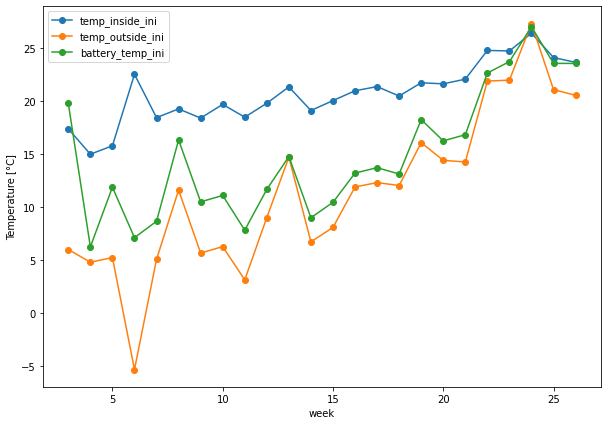

In [3]:
mean_temps.plot(style='o-', ylabel="Temperature [°C]", figsize=(10,7));
print("Fig. 1.")

As observed in table 1 and Fig 1, the mean temperatures reflect more the temperatures according to the season, so lower temperatures are expected during the first weeks of the year and these should increase once spring/summer is approaching. We can use these to replace the missing data in the original dataset. Note also how the battery and outside temperatures follow the same dependency with the week number with very similar temperature values. 

In [4]:
t_in_replace_values = data[data.temp_inside_ini.isna()].week.apply(lambda x: t_in_ini_mean_calendar_week.loc[x])
t_out_replace_values = data[data.temp_outside_ini.isna()].week.apply(lambda x: t_out_ini_mean_calendar_week.loc[x])
t_batt_replace_values = data[data.battery_temp_ini.isna()].week.apply(lambda x: t_batt_ini_mean_calendar_week.loc[x])

data["temp_inside_ini"].loc[t_in_replace_values.index.values] = t_in_replace_values.temp_inside_ini
data["temp_outside_ini"].loc[t_out_replace_values.index.values] = t_out_replace_values.temp_outside_ini
data["battery_temp_ini"].loc[t_batt_replace_values.index.values] = t_batt_replace_values.battery_temp_ini

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6853 entries, 0 to 6852
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   plugConfigurationInternalId  6853 non-null   object 
 1   soc_ini                      6853 non-null   float64
 2   speed                        6853 non-null   float64
 3   distance total               6853 non-null   float64
 4   battery_temp_ini             6853 non-null   float64
 5   temp_outside_ini             6853 non-null   float64
 6   temp_inside_ini              6853 non-null   float64
 7   altitude difference          6853 non-null   float64
 8   eff                          6853 non-null   float64
 9   f_kin                        6853 non-null   float64
 10  week                         6853 non-null   int64  
 11  day_week                     6853 non-null   int64  
 12  hour_day                     6853 non-null   int64  
dtypes: float64(9), int

The summary above shows now that the dataset has no missing values. 

### Wrong/bad data.

Now let try to see if there are other problems with the data that need to be addressed. So lets have a look at some data descriptive statistics.

In [5]:
print("Table 2. Descriptive statistics")
bad_soc = len(data[data.soc_ini > 100])
data.describe().round(2)

Table 2. Descriptive statistics


soc_ini    speed  distance total  battery_temp_ini  temp_outside_ini  \
count   6853.0  6853.00         6853.00           6853.00           6853.00   
mean      69.9    50.01           20.49             20.39             16.45   
std       22.5    24.37           26.00            111.83              7.17   
min        4.0     1.41            0.01             -9.00            -12.00   
25%       54.0    33.10            5.45             12.00             11.90   
50%       73.5    46.12           11.79             18.00             16.00   
75%       88.5    61.08           24.77             24.00             21.91   
max      120.0   311.93          293.80           6550.00             38.00   

       temp_inside_ini  altitude difference      eff    f_kin     week  \
count          6853.00              6853.00  6853.00  6853.00  6853.00   
mean             22.54                -6.24     0.96     0.68    19.69   
std               3.74                67.25     0.05     0.36     4.71   
min               2.00              -887.86     0.80     0.01     3.00   
25%              20.50               -24.16     0.94     0.39    16.00   
50%              22.00                -3.18     0.99     0.68    20.00   
75%              24.13                15.48     1.00     0.98    24.00   
max              40.00              1986.28     1.00     1.99    26.00   

       day_week  hour_day  
count   6853.00   6853.00  
mean       3.83     11.81  
std        1.90      4.32  
min        1.00      0.00  
25%        2.00      8.00  
50%        4.00     12.00  
75%        5.00     15.00  
max        7.00     23.00

Table 2 above shows statistics such as the number of entries, mean, standard deviation, the 25, 50 and 75 percentiles and the min and max values for the values in the columns of the dataset.

By closely inspecting these data we can observe two main problems. First, the *soc_ini* column has some values which are larger than 100, which is wrong. These are about 55 values that need to be replaced with a reasonable value. In this case we will use 100%. The second problem we see is that there are speed values which are too large. The max value is 311.9. Large speed values are just about three data points, so we will just filter out outliers by removing entries where the speed values are larger than the 0.99 quantile. Out of that, there are no other problems with the data that need to be solved. 

In the following cell we will correct these problems as explained.

In [6]:
# fix soc_ini problem
data["soc_ini"] = data.soc_ini.apply(lambda x: 100 if x > 100 else x)

# fix speed problem by removing outliers (> 99% percentile)
data = data[data.speed < data.speed.quantile(0.999)]
data[["soc_ini", "speed"]].describe().round(2)

soc_ini    speed
count  6846.00  6846.00
mean     69.78    49.87
std      22.29    23.93
min       4.00     1.41
25%      54.00    33.10
50%      73.50    46.10
75%      88.50    60.99
max     100.00   135.38

Above is again a table with statistics of the columns we just modified, as observed, the max values of soc_ini and speed are 100% and 135.38, respectively. 

### Adding complementary data.
Since we have the plug configuration information of the vehicle used for the minimized data, we can use this to complement our dataset with more data regarding the vehicle specifics which are relevant for estimating the energy consumption. Values such as the vehicle weight, frontal area, drag coefficient and netto battery size, for instance, can be added to the dataset. Moreover, having this numerical information can also help us to build a model which can generalize to unseen vehicles. 

## ML algorithm selection

Before we go deep into the machine learning model, let us first have a look again at the data and see if we can find already some correlations. Table 3 below shows the correlation matrix of the numeric data in the dataset. Without going to much into details we can see that overall, the correlations are rather weak (in the range -0.10 and 0.10), which could be a problem for machine learning since there are no particular dependences among the data. There are some strong correlations among the vehicle specific data (see lower right corner of the matrix), whereas medium correlations can be observed for the inside and outside temperatures and the week/day/hour data, as expected.

For the $f_{kin}$ and $eff$ parameters we see that they show a weak correlation with the other parameters, however slightly bigger (above $\pm 0.10$) than that among the other parameters. $f_{kin}$ shows mostly negative correlations with the largest correlated parameter being the *distance total*, so the larger the total distance, the smaller $f_{kin}$. Similar is observed for $eff$ although the correlation is positive, so the larger the distance, the larger $eff$. Regarding $f_{kin}$ this negative correlations are actually expected because the larger the speed, as in the case of an highway drive, the constant the speed is kept during the drive, so the less changes in acceleration. Hence, the larger the distance, the likelihood that the drive corresponds to a highway drive is higher.

In [7]:
# complement data with vehicle specifications
pcids = data.plugConfigurationInternalId.unique()

vehicle_specs = pd.DataFrame()
for pcid in pcids:
    pcid_spec = DatabaseHelper.query_vehicle_type_specs(pcid, plug_configuration=True)
    pcid_spec["plugConfigurationInternalId"] = pcid
    vehicle_specs = pd.concat([vehicle_specs, pcid_spec])

data_joined = (data.set_index("plugConfigurationInternalId")
               .join(vehicle_specs.set_index("plugConfigurationInternalId"), how="inner")
               .reset_index()
              )

print("Table 3. Correlation Matrix.")
data_joined.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

Table 3. Correlation Matrix.


Just to have a feeling of how the data looks like, lets plot a pair plot in which we plot all variables against each other. For this plot we will select the $f_{kin}$ and $eff$ parameters together with their higher correlated features. Figure 2 below shows such plot, the plots in the diagonal show a density plot for the given column. The colors represent the different vehicle models.

Fig. 2. Pair plot


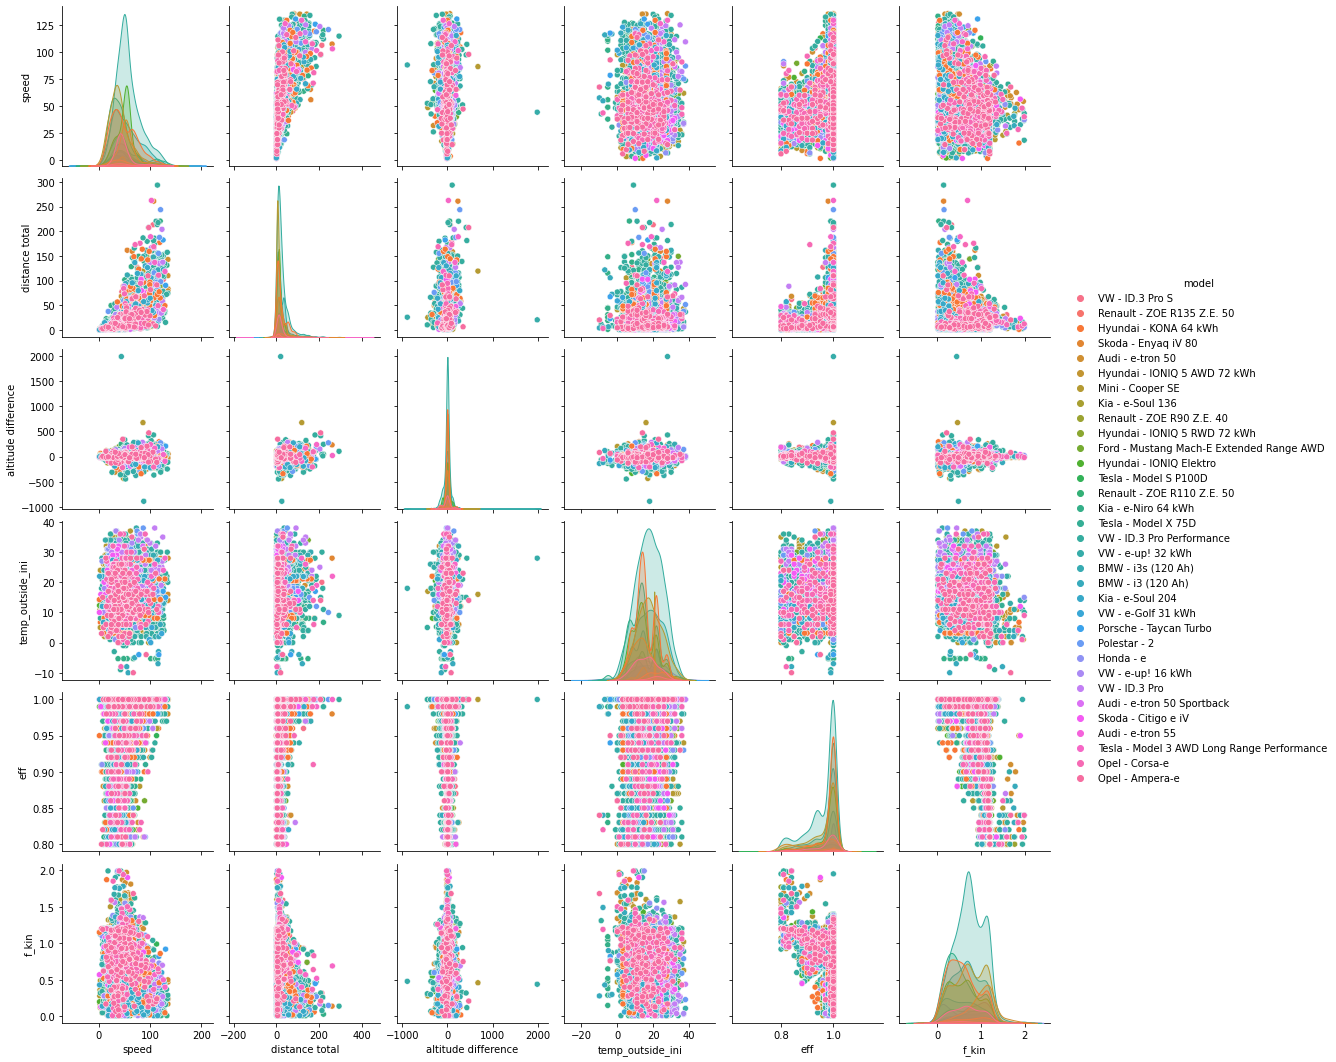

In [8]:
import seaborn as sns

cols = [
    'model',
    'speed',
    'distance total',
    'altitude difference',
    'temp_outside_ini',
    'eff',
    'f_kin',
]

print("Fig. 2. Pair plot")
sns.pairplot(data_joined[cols], hue="model");

Another important aspect we need to take into account before we start to search for machine learning algorithms, is to see if our data is unbalanced. This means, if we have enough statistically representative data for the different vehicle types.

As shown in table 4, there are vehicles with more available data than others. For instance, the ID.3 Performance have 1447 data entries which is about 21% of the total dataset, whereas the Renault Zoe  R110 has only 9 entries (0.1% from the total). This unbalance needs to be considered during model evaluation.

In [9]:
# number of data points (drives) per pcid
print("Table 4. Number of entries per Plug configuration id (vehicle types)")
data_proportion = (data_joined[["plugConfigurationInternalId", "model", "eff"]]
 .groupby(["plugConfigurationInternalId", "model"]).count()
 .sort_values(by="model")
 .rename(columns={"eff":"count"})
)
data_proportion["[%]"] = 100*(data_proportion["count"]/len(data_joined))
data_proportion.round(1)

Table 4. Number of entries per Plug configuration id (vehicle types)


count  \
plugConfigurationInternalId          model                                               
1956fcdb-885b-4cc3-9386-abbba7c600f2 Audi - e-tron 50                              306   
d4891fb8-13b5-4611-a2c5-5accb4b9b388 Audi - e-tron 50 Sportback                      5   
e71852a8-8c7d-4027-8bba-46aa16bcd9ca Audi - e-tron 55                                5   
9e07c035-794f-43d0-af08-4ae0ab28cfdd BMW - i3 (120 Ah)                             127   
9757b7fe-4291-4e06-b586-ef14737455d3 BMW - i3s (120 Ah)                             22   
4cebb709-709d-4162-82ff-62c8fd6794b3 Ford - Mustang Mach-E Extended Range AWD       24   
b2a60e40-262e-4316-abbf-ae70066d505b Honda - e                                      61   
28a5a4b7-dbb7-475e-99a4-16e822e03d1d Hyundai - IONIQ 5 AWD 72 kWh                   13   
43789dff-d9e7-411e-9060-721831752f6e Hyundai - IONIQ 5 RWD 72 kWh                   10   
65c25ef4-86c3-45f3-bfee-2a857ee1976e Hyundai - IONIQ Elektro                       499   
d4995d93-9c9b-4fcc-b064-9bfc38aa8881 Hyundai - KONA 64 kWh                         303   
148fafd7-4e04-4ffb-89b0-0c0016419575 Hyundai - KONA 64 kWh                         383   
7d6e2d58-bc59-41e3-bbce-82dd4653b925 Kia - e-Niro 64 kWh                           535   
6c455dee-61e6-4e3e-b93e-0f0cfd66ded2 Kia - e-Niro 64 kWh                           115   
335df537-8c9b-447d-8085-1a28692e435f Kia - e-Soul 136                               14   
a1c4bb81-38c6-4c48-bd47-7e797b5ee29f Kia - e-Soul 204                               68   
e82ec038-dddd-4c44-b529-9f5e647eb309 Kia - e-Soul 204                              234   
31fbee30-9bb2-406a-ac50-d936ee62bdc5 Mini - Cooper SE                              707   
f5eea254-c46e-4cdd-a1c4-5c999bf4e493 Opel - Ampera-e                               127   
f1cd24dd-5de4-49b7-8146-b582ae325f12 Opel - Corsa-e                                201   
b10414c0-2a1e-40a0-9271-3f2868bf360c Polestar - 2                                  121   
b045ddda-e34c-43e1-b50c-5e2a25b6016f Porsche - Taycan Turbo                         10   
67f3682e-b651-484f-ab07-50eea3ff5f1b Renault - ZOE R110 Z.E. 50                      9   
1218bf9f-88af-47a4-91e1-ea5174de483a Renault - ZOE R135 Z.E. 50                     21   
3b4ed3c0-5532-4c90-9962-298a4be5c490 Renault - ZOE R90 Z.E. 40                      36   
d6342652-08cf-4559-9ed9-65c98cd127c5 Skoda - Citigo e iV                            76   
1895f269-858c-4273-ad63-c497498c74ad Skoda - Enyaq iV 80                            63   
f1ac6b4d-c215-44fb-b065-86f92f078cc6 Tesla - Model 3 AWD Long Range Performance      7   
65ef1c08-d5e9-46bc-b0b4-187c305f2129 Tesla - Model S P100D                           8   
83265f72-1554-4518-b2bf-54b715b7c514 Tesla - Model X 75D                            26   
6c8d54f7-1c6c-4d1e-a3c3-9b4b892af205 Tesla - Model X 75D                           160   
bda7bed0-57a1-4ced-b84e-82b2947c9ff9 VW - ID.3 Pro                                 102   
84df9b13-2d63-4216-9217-f464e24ec59d VW - ID.3 Pro Performance                    1447   
0fc4e71b-6a98-4e12-bf5f-f55255efbdc3 VW - ID.3 Pro S                               192   
a42fbc95-f810-4a8b-94b9-04f7d1ffb0bf VW - e-Golf 31 kWh                             10   
b9a3f237-990d-463d-8fb8-5e448f6d6cb4 VW - e-up! 16 kWh                             115   
8e86ad4e-2429-42d4-b7fe-fd5e2919467d VW - e-up! 32 kWh                             684   

                                                                                  [%]  
plugConfigurationInternalId          model                                             
1956fcdb-885b-4cc3-9386-abbba7c600f2 Audi - e-tron 50                             4.5  
d4891fb8-13b5-4611-a2c5-5accb4b9b388 Audi - e-tron 50 Sportback                   0.1  
e71852a8-8c7d-4027-8bba-46aa16bcd9ca Audi - e-tron 55                             0.1  
9e07c035-794f-43d0-af08-4ae0ab28cfdd BMW - i3 (120 Ah)                            1.9  
9757b7fe-4291-4e06-b586-ef14737455d3 BMW -


### Strategy:

Since with our machine learning model we aim to get the values of motor efficiency ($eff$) and kinetic energy term ($f_{kin}$) from the available data, this problem can be categorized as a supervised multi-output regression problem. The target variables are $eff$ and $f_{kin}$ and the other will be the features.

In order to find a good machine learning algorithm that we can use, the following strategy will be used:

1. Subdivide the data into a Train and a test set, where the test set corresponds to 30% of the whole data. The division of the train and test set will be done keeping the vehicle types proportions. The test subset will be used for model validation.

2. We will use brute force, we will train several algorithms using a 5-fold cross validation method, where the train subset will be again subdivided into train and test subsets (keeping once again vehicle types proportions), the model will be trained with the new train subset and tested with the test subset. This process is repeated 5 times (5-fold). After each fold we determine a quality metrics score that represents how good are the predictions on the test data. The mean score of among the five folds will gives the final score for the model. The metric score that will be used is $r^2$. Where a $r^2=1$ means perfect prediction. Hence, models with $r^2$ closest to 1 are better.

3. Once the best algorithm is found we will try to fine tune it by optimizing its hyperparameters.

#### Train-Test split
Let us now start with the first step, where we split the data into train and test subsets keeping the vehicle types proportion.

In [10]:
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, train_test_split,
                                     StratifiedKFold, cross_val_score)
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    SGDRegressor, Lars, LassoLars, OrthogonalMatchingPursuit, 
    ARDRegression, HuberRegressor, TheilSenRegressor, BayesianRidge,
    LinearRegression, Lasso, ElasticNet, Ridge)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import (LinearSVR, NuSVR, NuSVR, SVR)
from sklearn.neural_network import MLPRegressor

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# make train test split
not_relevant_cols = ["plugConfigurationInternalId", "model"]
target_cols = ["eff", "f_kin"]
feature_cols = [col for col in data_joined.columns if col not in not_relevant_cols + target_cols]

# set features and targets
features = data_joined[[col for col in data_joined.columns if col not in target_cols]]
targets = data_joined[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, stratify= features["plugConfigurationInternalId"], test_size=0.3, random_state=42)

# stratified shuffle of test and train data
df = pd.concat([
X_test[["plugConfigurationInternalId", "speed"]].groupby("plugConfigurationInternalId").count()/len(X_test)*100,
X_train[["plugConfigurationInternalId", "speed"]].groupby("plugConfigurationInternalId").count()/len(X_train)*100
], axis=1)
df.columns=["test", "train"]
print("Table 5. Stratified shuffle of train and test data")
df.round(2)

Table 5. Stratified shuffle of train and test data


test  train
plugConfigurationInternalId                       
0fc4e71b-6a98-4e12-bf5f-f55255efbdc3   2.82   2.80
1218bf9f-88af-47a4-91e1-ea5174de483a   0.29   0.31
148fafd7-4e04-4ffb-89b0-0c0016419575   5.60   5.59
1895f269-858c-4273-ad63-c497498c74ad   0.93   0.92
1956fcdb-885b-4cc3-9386-abbba7c600f2   4.48   4.47
28a5a4b7-dbb7-475e-99a4-16e822e03d1d   0.19   0.19
31fbee30-9bb2-406a-ac50-d936ee62bdc5  10.32  10.33
335df537-8c9b-447d-8085-1a28692e435f   0.19   0.21
3b4ed3c0-5532-4c90-9962-298a4be5c490   0.54   0.52
43789dff-d9e7-411e-9060-721831752f6e   0.15   0.15
4cebb709-709d-4162-82ff-62c8fd6794b3   0.34   0.35
65c25ef4-86c3-45f3-bfee-2a857ee1976e   7.30   7.28
65ef1c08-d5e9-46bc-b0b4-187c305f2129   0.10   0.13
67f3682e-b651-484f-ab07-50eea3ff5f1b   0.15   0.13
6c455dee-61e6-4e3e-b93e-0f0cfd66ded2   1.70   1.67
6c8d54f7-1c6c-4d1e-a3c3-9b4b892af205   2.34   2.34
7d6e2d58-bc59-41e3-bbce-82dd4653b925   7.84   7.80
83265f72-1554-4518-b2bf-54b715b7c514   0.39   0.38
84df9b13-2d63-4216-9217-f464e24ec59d  21.13  21.14
8e86ad4e-2429-42d4-b7fe-fd5e2919467d   9.98  10.00
9757b7fe-4291-4e06-b586-ef14737455d3   0.34   0.31
9e07c035-794f-43d0-af08-4ae0ab28cfdd   1.85   1.86
a1c4bb81-38c6-4c48-bd47-7e797b5ee29f   0.97   1.00
a42fbc95-f810-4a8b-94b9-04f7d1ffb0bf   0.15   0.15
b045ddda-e34c-43e1-b50c-5e2a25b6016f   0.15   0.15
b10414c0-2a1e-40a0-9271-3f2868bf360c   1.75   1.77
b2a60e40-262e-4316-abbf-ae70066d505b   0.88   0.90
b9a3f237-990d-463d-8fb8-5e448f6d6cb4   1.70   1.67
bda7bed0-57a1-4ced-b84e-82b2947c9ff9   1.51   1.48
d4891fb8-13b5-4611-a2c5-5accb4b9b388   0.05   0.08
d4995d93-9c9b-4fcc-b064-9bfc38aa8881   4.43   4.42
d6342652-08cf-4559-9ed9-65c98cd127c5   1.12   1.11
e71852a8-8c7d-4027-8bba-46aa16bcd9ca   0.05   0.08
e82ec038-dddd-4c44-b529-9f5e647eb309   3.41   3.42
f1ac6b4d-c215-44fb-b065-86f92f078cc6   0.10   0.10
f1cd24dd-5de4-49b7-8146-b582ae325f12   2.92   2.94
f5eea254-c46e-4cdd-a1c4-5c999bf4e493   1.85   1.86

Table 5 above shows the proportion in percentage of data entries for the different vehicle types in both the train and test subsets. As observed in both subsets the proportions are kept. 

#### Algorithm check.
Now we proceed with step 2 where we check different algorithms. At first we will check algorithms that natively  allow for multi-output regression. In the cell below are listed the algorithms we will try. These are listed as mod1 to mod14. 

In [11]:
from sklearn.metrics import r2_score
# algorithms to try
mod1 = LinearRegression()
mod2 = ExtraTreeRegressor()
mod3 = Lasso(random_state=42)
mod4 = ElasticNet(random_state=42)
mod5 = KNeighborsRegressor(n_jobs=-1)
mod6 = RandomForestRegressor(random_state=42, n_jobs=-1)
mod7 = make_pipeline(StandardScaler(), MLPRegressor())
mod8 = Ridge(random_state=42)
mod9 = ExtraTreesRegressor(random_state=42)
mod10 = Lars(random_state=42)
mod11 = LassoLars(random_state=42)
mod12 = OrthogonalMatchingPursuit()
mod13 = make_pipeline(StandardScaler(), GaussianProcessRegressor())
mod14 = KernelRidge()

models = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8,mod9,mod10,mod11,mod12,mod13,mod14]
labels = ["mod1", "mod2", "mod3", "mod4", "mod5", "mod6", "mod7", "mod8","mod9","mod10","mod11","mod12","mod13","mod14"]

def compare_model_scores(models, X, y, labels, groups=None):
    """
    This function compares predictive scores from different ML algorithms
    """
    if groups is not None:
        scores = [{"model": labels[i],
                   "score": cross_val_score(model, X, y, cv=skf.split(X, groups), n_jobs=-1, scoring="r2").mean(),
                 } for i, model in enumerate(models)]
    else:
        scores = [{"model": labels[i],
                   "score": cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring="r2").mean(),
                 } for i, model in enumerate(models)]

    return (
        pd.DataFrame(scores)
        .set_index("model")
        .sort_values(by="score", ascending=False)
        .round(3)
           )
print("Table 6. Top 5 algorithm scores.")
compare_model_scores(models, X_train[feature_cols], y_train, labels, 
                     groups=X_train["plugConfigurationInternalId"]).head()

Table 6. Top 5 algorithm scores.


score
model       
mod6   0.280
mod9   0.269
mod5   0.149
mod10  0.110
mod1   0.110

Table 6 above shows the top 5 algorithm scores after performing the 5-fold cross validation. From the table we see that among the 14 algorithms tried so far there are two which perform the best with an $r^2$ values above 0.26. These are mod6 and mod9 a RandomForestRegressor and an ExtraTreesRegressor, respectively.

##### Direct Multi-output regression
Before we go into model fine tuning, lets try to check some more models that do not natively allow for multi-output. This we will do using a strategy called direct multi-output in which the regression problem is divided into a separate problem for each available target variable to be predicted. This assumes that the outputs are independent of each other, which might not be a correct assumption judging for the medium correlation between $eff$ and $f_{kin}$ (see table 3). Lets try this approach, nevertheless, and see if we can find a model that can perform better than the two models above preselected.

In the cell below are listed 10 algorithms for direct multi-output, let us evaluate them using 5-fold cross validation. 

In [12]:
from sklearn.multioutput import MultiOutputRegressor

mod1 = MultiOutputRegressor(LinearSVR(random_state=42))
mod2 = MultiOutputRegressor(HuberRegressor())
mod3 = MultiOutputRegressor(ARDRegression())
mod4 = MultiOutputRegressor(TheilSenRegressor())
mod5 = MultiOutputRegressor(BayesianRidge())
mod6 = MultiOutputRegressor(make_pipeline(StandardScaler(),LinearSVR()))
mod7 = MultiOutputRegressor(make_pipeline(StandardScaler(),NuSVR()))
mod8 = MultiOutputRegressor(SVR())
mod9 = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
mod10 = MultiOutputRegressor(AdaBoostRegressor(random_state=42))

models = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8,mod9,mod10]
labels = ["mod1", "mod2", "mod3", "mod4", "mod5", "mod6", "mod7", "mod8","mod9","mod10"]

print("Table 6. Top 5 scores for direct multi-output models.")
compare_model_scores(models, X_train[feature_cols], y_train, labels, 
                     groups=X_train["plugConfigurationInternalId"]).head()

Table 6. Top 5 scores for direct multi-output models.


score
model       
mod9   0.266
mod7   0.174
mod10  0.119
mod5   0.107
mod4   0.063

Table 6 above shows the $r^2$ values of the best 5 direct multi-output models. The best one is mod9 corresponding to a GradientBoostingRegressor algorithm. Its $r^2$ value, however, is close, but still below the $r^2$ values of the models checked in the previous state.

##### Chained multi-output regression
There is another strategy to try multi-output regression and this is the chained multi-output regression. In this strategy one creates a sequence of models , the first model in the sequence uses the features as input and creates one output, which is the prediction of the first target variable. Then the second model uses the input and the output from the first model to make a prediction of the second target variable. 

In the cell below we will try this method with all algorithms tried so far. 

In [13]:
from sklearn.multioutput import RegressorChain
order = [1,0]
mod1 = RegressorChain(LinearRegression(), order=order)
mod2 = RegressorChain(AdaBoostRegressor(random_state=42), order=order)
mod3 = RegressorChain(Lasso(random_state=42), order=order)
mod4 = RegressorChain(ElasticNet(random_state=42), order=order)
mod5 = RegressorChain(KNeighborsRegressor(n_jobs=-1), order=order)
mod6 = RegressorChain(RandomForestRegressor(random_state=42, n_jobs=-1), order=order)
mod7 = RegressorChain(LinearSVR(random_state=42), order=order)
mod8 = RegressorChain(Ridge(random_state=42), order=order)
mod9 = RegressorChain(ExtraTreesRegressor(random_state=42), order=order)
mod10 = RegressorChain(Lars(), order=order)
mod11 = RegressorChain(LassoLars(), order=order)
mod12 = RegressorChain(OrthogonalMatchingPursuit(), order=order)
mod13 = RegressorChain(HuberRegressor(), order=order)
mod14 = RegressorChain(ARDRegression(), order=order)
mod15 = RegressorChain(TheilSenRegressor(), order=order)
mod16 = RegressorChain(BayesianRidge(), order=order)
mod17 = RegressorChain(make_pipeline(StandardScaler(), GaussianProcessRegressor()), order=order)
mod18 = RegressorChain(KernelRidge(), order=order)
mod19 = RegressorChain(GradientBoostingRegressor(random_state=42), order=order)
mod20 = RegressorChain(make_pipeline(StandardScaler(),MLPRegressor()), order=order)
mod21 = RegressorChain(make_pipeline(StandardScaler(),LinearSVR()), order=order)
mod22 = RegressorChain(make_pipeline(StandardScaler(),NuSVR()), order=order)
mod23 = RegressorChain(SVR(), order=order)
mod24 = RegressorChain(ExtraTreeRegressor(), order=order)

models = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8,mod9,mod10,mod11,mod12,mod13,mod14,mod15,mod16,mod17,mod18,mod19,mod20,mod21,mod22,mod23,mod24]
labels = ["mod1", "mod2", "mod3", "mod4", "mod5", "mod6", "mod7", "mod8","mod9","mod10","mod11","mod12","mod13","mod14","mod15","mod16","mod17","mod18","mod19","mod20","mod21","mod22","mod23","mod24"]

print("Table 7. Top 5 scores for Chained multi-output regression.")
compare_model_scores(models, X_train[feature_cols], y_train, labels, groups=X_train["plugConfigurationInternalId"]).head()

Table 7. Top 5 scores for Chained multi-output regression.


score
model       
mod9   0.224
mod19  0.221
mod6   0.220
mod22  0.169
mod5   0.149

As observed in table 7 above, the top 5 scores of the chained strategy are not better than 0.27, hence, we will not consider this approach.

To summarize, so far we have tried several algorithms and several approaches to achieve a multi-output regression as the one we need to predict $eff$ and $f_{kin}$. From this preselection round using 5-fold cross validation we end up with three potential algorithms that we can try to further improve by fine tuning them. These algorithms are the RandomForestRegressor, ExtraTressRegressor and the GradientBoostingRegressor.

### Hyperparameter optimization

Alright, we are now ready to fine tune our models, in order to do that we need first to define a starting point, a base metric that tells us if we are actually improving our model or not. For that we will use three metrics:
1. The mean absolute error (MAE), which is the mean error between the predicted and the real target value. Perfect predictors will yield a MAE of 0.  
2. The accuracy, which basically tells us in percentage, how far are we from the real prediction. Perfect prediction has a 100% accuracy.
3. The coefficient of determination $r^2$. Best value is 1. 

Table 8 below shows these values for the three preselected models. This table will be our basis that will help us judge if there is some improvement after fine tuning.

It is worth mentioning that, since we are in a preliminary test phase and the data available is not particularly large, we will focus in the MAE value. Our aim will be to reduce this value as much as possible. 

In [14]:
import numpy as np
def evaluate_model(model, features, targets):
    predictions = model.predict(features)
    errors = abs(predictions[:,1] - targets["f_kin"])
    ape = 100 * (errors / targets["f_kin"])
    ape = ape[ape < ape.quantile(0.99)]
    mape = ape.mean()
    accuracy = 100 - mape
    r2_score = model.score(features, targets)

    return pd.DataFrame({"MAE":errors.mean(), 
                         "Accuracy [%]": accuracy, 
                         r"$r^2$": r2_score}, index=[0]).round(3)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

models = [rf, etr, gbr]
model_names = ["Random Forest", "Extra Trees", "Gradient Boosting"]

base_scores = pd.DataFrame()
for i, model in enumerate(models):
    model.fit(X_train[feature_cols], y_train)
    res = evaluate_model(model, X_test[feature_cols], y_test)
    res["model"] = model_names[i]
    base_scores = pd.concat([base_scores, res])

print("Table 8. Base scores.")
base_scores.set_index("model")

Table 8. Base scores.


MAE  Accuracy [%]  $r^2$
model                                        
Random Forest      0.227        27.745  0.292
Extra Trees        0.229        28.036  0.270
Gradient Boosting  0.234        25.879  0.270

Lets start with the RandomForestRegressor. For the hyperparameter tuning we will use a grid of parameters that we will combine and then evaluate the model with a 5-fold cross validation. The combination with the best score will be selected. This procedure is called a grid search. Once the best parameter combination is found we then validate it with our Test dataset and see if there is an improvement with respect to the values in table 8.

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Hyperparams optimization for RandomForestRegressor
param_grid = {
    'n_estimators': [200, 900, 1300],
    'min_samples_leaf': [n for n in range(2,11,2)],
    'min_samples_split': [n for n in range(2,11,2)],
}

# Create a based model
rf_hp = RandomForestRegressor(random_state=42, n_jobs=-1)
# Instantiate the grid search model
rf_grid_search = GridSearchCV(
    estimator=rf_hp,
    param_grid=param_grid,
    cv=skf.split(X_train[feature_cols], X_train["plugConfigurationInternalId"]),
    n_jobs=-1,
    verbose = 2)

rf_grid_search.fit(X_train[feature_cols], y_train)
print(rf_grid_search.best_params_, rf_grid_search.best_score_)

rf_ft = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
rf_ft.fit(X_train[feature_cols], y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1300} 0.2864570686468636


RandomForestRegressor(min_samples_leaf=4, n_estimators=1300, n_jobs=-1,
                      random_state=42)

In [16]:
rf_base = evaluate_model(rf, X_test[feature_cols], y_test)
rf_base["Optimization"] = "before"

rf_after = evaluate_model(rf_ft, X_test[feature_cols], y_test)
rf_after["Optimization"] = "after"

print("Table 9. Random Forest metrics before and after fine tuning.")
pd.concat([rf_base, rf_after]).set_index("Optimization")

Table 9. Random Forest metrics before and after fine tuning.


MAE  Accuracy [%]  $r^2$
Optimization                            
before        0.227        27.745  0.292
after         0.227        27.412  0.296

Table 9 above show the metrics for the Random Forest model before and after the fine tuning of hyperparameters. As observed, the $r^2$ value shows a small improvement, although, the accuracy is also slightly reduced.

Lets now check if we can get better results with the next model that we have preselected, namely the Extra Trees Regressor.

Table 10 below shows again the comparison of the metrics before and after the hyperparameter optimization. As observed there is also some improvement in both the MAE and $r^2$, but this time the decrease in accuracy is larger than for the Random Forest.

In [17]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Hyperparams optimization for ExtraTreesRegrassor
param_grid = {
    'n_estimators': [500, 1000, 1800],
    'min_samples_leaf': [n for n in range(2,11,2)],
    'min_samples_split': [n for n in range(2,11,2)],
}

# Create a based model
etr_hp = ExtraTreesRegressor(random_state=42, n_jobs=-1)
# Instantiate the grid search model
etr_grid_search = GridSearchCV(
    estimator=etr_hp,
    param_grid=param_grid,
    cv=skf.split(X_train[feature_cols], X_train["plugConfigurationInternalId"]),
    n_jobs=-1,
    verbose = 2)

etr_grid_search.fit(X_train[feature_cols], y_train)
print(etr_grid_search.best_params_, etr_grid_search.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000} 0.2835737204653107


In [18]:
etr_ft = RandomForestRegressor(**etr_grid_search.best_params_, random_state=42, n_jobs=-1)
etr_ft.fit(X_train[feature_cols], y_train)

etr_base = evaluate_model(etr, X_test[feature_cols], y_test)
etr_base["Optimization"] = "before"

etr_after = evaluate_model(etr_ft, X_test[feature_cols], y_test)
etr_after["Optimization"] = "after"

print("Table 10. Extra Trees metrics before and after fine tuning.")
pd.concat([etr_base, etr_after]).set_index("Optimization")

Table 10. Extra Trees metrics before and after fine tuning.


MAE  Accuracy [%]  $r^2$
Optimization                            
before        0.229        28.036  0.270
after         0.227        27.586  0.298

Lets finally optimize the Gradient Boosting algorithm in the same way as we did for the other two models.

In [19]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Hyperparams optimization for GradientBoosting
param_grid = {
    'estimator__max_depth': [n for n in range(2,11,2)],
    'estimator__min_samples_leaf': [n for n in range(2,11,2)],
    'estimator__min_samples_split': [n for n in range(2,11,2)],
}

# Create a based model
gbr_hp = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
# Instantiate the grid search model
gbr_grid_search = GridSearchCV(
    estimator=gbr_hp,
    param_grid=param_grid,
    cv=skf.split(X_train[feature_cols], X_train["plugConfigurationInternalId"]),
    n_jobs=-1,
    verbose = 2)

gbr_grid_search.fit(X_train[feature_cols], y_train)
print(gbr_grid_search.best_params_, gbr_grid_search.best_score_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
{'estimator__max_depth': 4, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2} 0.2736297057302345


In [20]:
gbr_ft = RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=2, random_state=42, n_jobs=-1)
gbr_ft.fit(X_train[feature_cols], y_train)

gbr_base = evaluate_model(gbr, X_test[feature_cols], y_test)
gbr_base["Optimization"] = "before"

gbr_after = evaluate_model(gbr_ft, X_test[feature_cols], y_test)
gbr_after["Optimization"] = "after"

print("Table 11. Gradient Boosting metrics before and after fine tuning.")
pd.concat([gbr_base, gbr_after]).set_index("Optimization")

Table 11. Gradient Boosting metrics before and after fine tuning.


MAE  Accuracy [%]  $r^2$
Optimization                            
before        0.234        25.879  0.270
after         0.259        12.287  0.176

Table 11 above shows the metrics of the optimization, as can be seen, there was no real improvement, on the contrary, the model got much worst. This means that the default set up of the algorithm give us the best result for this model.

One last thing we can try to see if we can improve the prediction power of our models is by trying a combination of these. This technique is called ensemble voting and it uses a set of regressors and averages their predictions to yield a final prediction.

In [21]:
from sklearn.ensemble import VotingRegressor

rf_v = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
etr_v = ExtraTreesRegressor(**etr_grid_search.best_params_, random_state=42, n_jobs=-1)

voting_r = MultiOutputRegressor(VotingRegressor([('RandomForest', rf_v),
                                                 ('ExtraTrees', etr_v),
                                                ],
                                                n_jobs=-1))
voting_r.fit(X_train[feature_cols], y_train)

_ = pd.concat([
    evaluate_model(rf_ft, X_test[feature_cols], y_test),
    evaluate_model(etr_ft, X_test[feature_cols], y_test),
    evaluate_model(voting_r, X_test[feature_cols], y_test)
])
_["model"]=["Random Forest", "Extra Trees", "Voting"]
print("Table 12. Comparison of optimized Models and Voting")
_.set_index("model")

Table 12. Comparison of optimized Models and Voting


MAE  Accuracy [%]  $r^2$
model                                    
Random Forest  0.227        27.412  0.296
Extra Trees    0.227        27.586  0.298
Voting         0.227        27.177  0.298

Table 11 above shows the metrics for the optimized models and the voting ensemble model. As observed, the ensemble model shows an overall slight improvement with an increase in accuracy and a slight reduction of MAE. The $r^2$ value is basically the same for all of them. Hence, we will choose the voting model as our final one.

## Is there any improvement?

Considering that the optimized models metrics are not as good as one would expect. For instance an accuracy of 16% is still far from 100% and $r^2=0.3$ is still far from 1. The question that arises is, if this model will represent an improvement with respect to our actual approach to the problem. 

Remember that the actual approach consist of using fix averages values of $f_{kin}$ and $eff$, which is rather a rough approximation.

So basically what we will do is for each entry in the test dataset, we will predict the value of $eff$ and $f_{kin}$ with our optimized model and calculate the mean absolute error (MAE) with respect to the real values. After that we calculate the MAE between the real values and the mean that we currently use in the routing algorithm. Then we compare these two EMAs and determine in which percent it has improved.

In [22]:
def get_mongo_consumption():
    query = {"active":True}
    fields = {"plugConfigurationInternalId":1, "motorEfficiency":1,
              "kineticFactorHighway": 1, "kineticFactorCity": 1, "_id": 0}

    with DatabaseHelper.connect_mongodb() as conn:
        collection = conn[get_config().MONGODB_DB][
            get_config().MONGODB_COLLECTION_ANALYSIS_ANONYMOUS
        ]
        response = pd.DataFrame(
            list(collection.find(query, fields))
        )
    return response

consumption_mongo = get_mongo_consumption()

mean_consumption_values_current = (consumption_mongo
 .set_index("plugConfigurationInternalId")
 .join(data_joined.set_index("plugConfigurationInternalId")[["model"]], how="inner")
 .groupby(["plugConfigurationInternalId", "model"]).mean()
           ).sort_values(by="model").round(3)
print("Table 13. Example of some eff and f_kin mean values used currently in the Routing Algo.")
mean_consumption_values_current.head()

Table 13. Example of some eff and f_kin mean values used currently in the Routing Algo.


motorEfficiency  \
plugConfigurationInternalId          model                                         
1956fcdb-885b-4cc3-9386-abbba7c600f2 Audi - e-tron 50                       0.89   
d4891fb8-13b5-4611-a2c5-5accb4b9b388 Audi - e-tron 50 Sportback             0.95   
e71852a8-8c7d-4027-8bba-46aa16bcd9ca Audi - e-tron 55                       0.84   
9e07c035-794f-43d0-af08-4ae0ab28cfdd BMW - i3 (120 Ah)                      0.92   
9757b7fe-4291-4e06-b586-ef14737455d3 BMW - i3s (120 Ah)                     0.95   

                                                                 kineticFactorHighway  \
plugConfigurationInternalId          model                                              
1956fcdb-885b-4cc3-9386-abbba7c600f2 Audi - e-tron 50                            0.83   
d4891fb8-13b5-4611-a2c5-5accb4b9b388 Audi - e-tron 50 Sportback                  0.56   
e71852a8-8c7d-4027-8bba-46aa16bcd9ca Audi - e-tron 55                            0.95   
9e07c035-794f-43d0-af08-4ae0ab28cfdd BMW - i3 (120 Ah)                           0.54   
9757b7fe-4291-4e06-b586-ef14737455d3 BMW - i3s (120 Ah)                          0.17   

                                                                 kineticFactorCity  
plugConfigurationInternalId          model                                          
1956fcdb-885b-4cc3-9386-abbba7c600f2 Audi - e-tron 50                         1.05  
d4891fb8-13b5-4611-a2c5-5accb4b9b388 Audi - e-tron 50 Sportback               0.70  
e71852a8-8c7d-4027-8bba-46aa16bcd9ca Audi - e-tron 55                         1.11  
9e07c035-794f-43d0-af08-4ae0ab28cfdd BMW - i3 (120 Ah)                        0.88  
9757b7fe-4291-4e06-b586-ef14737455d3 BMW - i3s (120 Ah)                       0.65

Table 13 above shows some representative values of the mean $eff$ and $f_{kin}$ values user currently in the routing algorithm. Notice that $f_{kin}$ is subdivided into city and Highway depending on the speed velocity of the route, so for example, if the route has a mean speed below or equal to 60km/h the $f_{kin}$ for city will be used, if is higher, then the highway value is used.

In [23]:
def get_improvement(new_x, new_y, model, eff, f_kin):
    predictions = pd.DataFrame(model.predict(new_x), columns=["eff_pred", "f_kin_pred"])
    res = pd.concat([new_y.reset_index(drop=True), predictions], axis=1)
    res["f_kin_pred_mape"] = abs(res.f_kin-res.f_kin_pred) 
    res["f_kin_mean_mape"] = abs(res.f_kin-f_kin) 

    pred_me = res.f_kin_pred_mape.mean()

    mean_me = res.f_kin_mean_mape.mean()
    return 100*(mean_me-pred_me)/mean_me, res

def check_error_improvement(model, X, y, eff, f_kin_ct, f_kin_hw):
    mask_city = (X.speed <= 60) 
    X_city = X[mask_city]
    y_city = y[mask_city]
    mask_hw = (X.speed > 60) 
    X_hw = X[mask_hw]
    y_hw = y[mask_hw]

    eff_pred_mape = abs(y.eff-model.predict(X)[:,0]).mean() 
    eff_mean_mape = abs(y.eff-eff).mean() 
    eff_improvement = 100*(eff_mean_mape - eff_pred_mape)/eff_mean_mape
    

    if 0 in [len(X_city), len(y_city), len(X_hw), len(y_hw)]:
             return None, None, None
    else:
        ct_improvement, _ = get_improvement(X_city, y_city, model, eff, f_kin_ct)
        hw_improvement, _ = get_improvement(X_hw, y_hw, model, eff, f_kin_hw)
        return ct_improvement, hw_improvement, eff_improvement
    
error_improvement = pd.DataFrame()
for auto in mean_consumption_values_current.reset_index().itertuples():
    mask = (X_test["plugConfigurationInternalId"] == auto.plugConfigurationInternalId)
    X_new = X_test[mask]
    ct_improvement, hw_improvement, eff_improvement = check_error_improvement(
#         etr_ft, X_new[feature_cols], y_test[mask], auto.motorEfficiency, auto.kineticFactorCity,
        voting_r, X_new[feature_cols], y_test[mask], auto.motorEfficiency, auto.kineticFactorCity,
        auto.kineticFactorHighway)
    auto_df = pd.DataFrame({
        "plugConfiguration":[auto.plugConfigurationInternalId],
        "model":[auto.model],
        "f_k City Improvement [%]":[ct_improvement],
        "f_k Highway Improvement [%]":[hw_improvement],
        "Eff Improvement [%]":[eff_improvement],
                           })
    error_improvement = pd.concat([error_improvement, auto_df])

print("Table 14. Error improvement in [%]")

error_improvement = error_improvement.replace(-np.inf, np.nan).dropna()
error_improvement.set_index("model").round(2)

Table 14. Error improvement in [%]


plugConfiguration  \
model                                                                            
Audi - e-tron 50                          1956fcdb-885b-4cc3-9386-abbba7c600f2   
BMW - i3 (120 Ah)                         9e07c035-794f-43d0-af08-4ae0ab28cfdd   
BMW - i3s (120 Ah)                        9757b7fe-4291-4e06-b586-ef14737455d3   
Ford - Mustang Mach-E Extended Range AWD  4cebb709-709d-4162-82ff-62c8fd6794b3   
Honda - e                                 b2a60e40-262e-4316-abbf-ae70066d505b   
Hyundai - IONIQ 5 AWD 72 kWh              28a5a4b7-dbb7-475e-99a4-16e822e03d1d   
Hyundai - IONIQ Elektro                   65c25ef4-86c3-45f3-bfee-2a857ee1976e   
Hyundai - KONA 64 kWh                     d4995d93-9c9b-4fcc-b064-9bfc38aa8881   
Hyundai - KONA 64 kWh                     148fafd7-4e04-4ffb-89b0-0c0016419575   
Kia - e-Niro 64 kWh                       7d6e2d58-bc59-41e3-bbce-82dd4653b925   
Kia - e-Niro 64 kWh                       6c455dee-61e6-4e3e-b93e-0f0cfd66ded2   
Kia - e-Soul 204                          a1c4bb81-38c6-4c48-bd47-7e797b5ee29f   
Kia - e-Soul 204                          e82ec038-dddd-4c44-b529-9f5e647eb309   
Mini - Cooper SE                          31fbee30-9bb2-406a-ac50-d936ee62bdc5   
Opel - Ampera-e                           f5eea254-c46e-4cdd-a1c4-5c999bf4e493   
Opel - Corsa-e                            f1cd24dd-5de4-49b7-8146-b582ae325f12   
Polestar - 2                              b10414c0-2a1e-40a0-9271-3f2868bf360c   
Renault - ZOE R110 Z.E. 50                67f3682e-b651-484f-ab07-50eea3ff5f1b   
Skoda - Citigo e iV                       d6342652-08cf-4559-9ed9-65c98cd127c5   
Skoda - Enyaq iV 80                       1895f269-858c-4273-ad63-c497498c74ad   
Tesla - Model X 75D                       83265f72-1554-4518-b2bf-54b715b7c514   
Tesla - Model X 75D                       6c8d54f7-1c6c-4d1e-a3c3-9b4b892af205   
VW - ID.3 Pro                             bda7bed0-57a1-4ced-b84e-82b2947c9ff9   
VW - ID.3 Pro Performance                 84df9b13-2d63-4216-9217-f464e24ec59d   
VW - ID.3 Pro S                           0fc4e71b-6a98-4e12-bf5f-f55255efbdc3   
VW - e-up! 16 kWh                         b9a3f237-990d-463d-8fb8-5e448f6d6cb4   
VW - e-up! 32 kWh                         8e86ad4e-2429-42d4-b7fe-fd5e2919467d   

                                          f_k City Improvement [%]  \
model                                                                
Audi - e-tron 50                                             15.05   
BMW - i3 (120 Ah)                                            18.28   
BMW - i3s (120 Ah)                                           37.66   
Ford - Mustang Mach-E Extended Range AWD                     -2.36   
Honda - e                                                    -5.85   
Hyundai - IONIQ 5 AWD 72 kWh                                 17.02   
Hyundai - IONIQ Elektro                                      14.25   
Hyundai - KONA 64 kWh                                        17.36   
Hyundai - KONA 64 kWh                                        11.46   
Kia - e-Niro 64 kWh                                          19.48   
Kia - e-Niro 64 kWh                                          -1.17   
Kia - e-Soul 204                                            -16.55   
Kia - e-Soul 204                                             12.65   
Mini - Cooper SE                                              9.37   
Opel - Ampera-e                                               4.47   
Opel - Corsa-e                                               -1.47   
Polestar - 2                                                 11.29   
Renault - ZOE R110 Z.E. 50                                  -58.07   
Skoda - Citigo e iV                                           8.02   
Skoda - Enyaq iV 80                                          -5.43   
Tesla - Model X 75D                                         -13.74   
Tesla - Model X 75D                                           5.44   
VW

Table 14 above shows the error improvement from the mean approach. Overall there is a remarkable improvement for the majority of vehicle models. Some exceptions are the Skoda Citigo, which its city $f_{kin}$ has gotten 262% worst. A reason for this is probably the fact that there are not many data points for this vehicle. In table 4 one can see that there are only 76 data points for this car for which only 5 of them correspond to highway data. The Renault Zoe R110 and the Ford Mustang are other vehicles that do not show an improvement of the EMA.

The most worsening of the MAE is observed in the Highway $f_{kin}$ (see fig.2 middle), this is, as mentioned already, mainly due to the fact that there are not many data points for highway speeds for many of the cars. Actually the amount of data for speeds lager than 60 km/h is about 25% of the total. This should improve once more data is collected.

Figure 3 below, shows a bar plot of the error improvement for a more visual appreciation of the effect. 

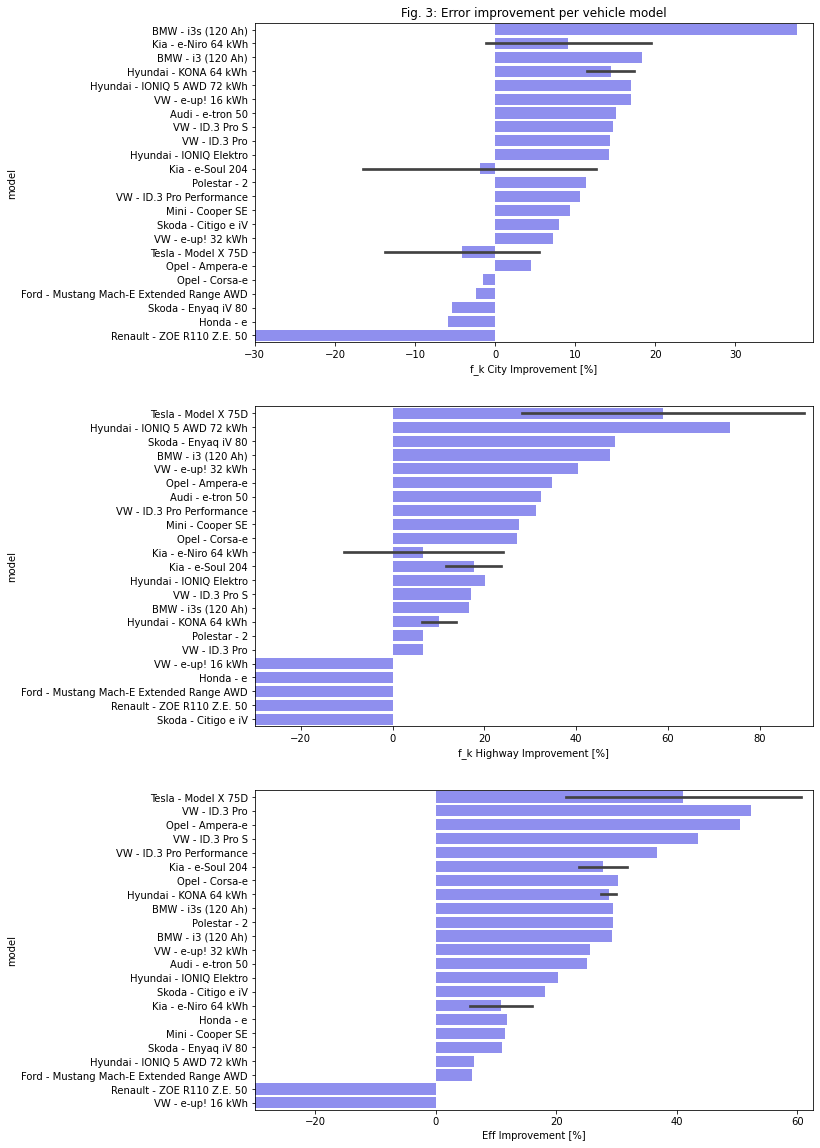

In [24]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(3, 1, figsize=(10,20))

data = error_improvement.sort_values(by="f_k City Improvement [%]", ascending=False)
sns.barplot(x="f_k City Improvement [%]",
            y="model",
           data=data,
           color="blue",
           alpha=0.5,
           ax=axs[0])
axs[0].set_xlim(-30,max(data["f_k City Improvement [%]"])+2)

data = error_improvement.sort_values(by="f_k Highway Improvement [%]", ascending=False)
sns.barplot(x="f_k Highway Improvement [%]",
            y="model",
           data=data,
           color="blue",
           alpha=0.5,
           ax=axs[1])
axs[1].set_xlim(-30,max(data["f_k Highway Improvement [%]"])+2)

data = error_improvement.sort_values(by="Eff Improvement [%]", ascending=False)
sns.barplot(x="Eff Improvement [%]",
            y="model",
           data=data,
           color="blue",
           alpha=0.5,
           ax=axs[2])

axs[0].set_title("Fig. 3: Error improvement per vehicle model")
axs[2].set_xlim(-30,max(data["Eff Improvement [%]"])+2);


As observed in the figure above, for most of the vehicles the improvement is actually very good. Bars with black lines correspond to vehicles which have different plug configurations (same model). The bar is an average between the vehicle types (plug configurations) of the same model. The black lines shows the error bar of the data. 

The table below shows the descriptive statistics of the overall improvement on MAE if we use the machine learning model as compared to the mean approach. The table shows for instance that for all the vehicles the mean improvement for the city and highway $f_{kin}$ is 6% and -5%, respectively. Since mean values are largely affected by outliers it is actually better to consider the quantiles in order to properly judge if there is an improvement in the majority of the data or not. In this regard the median (50% quantile) is more reliable statistic. The median tells us that half of the data shows an improvement of 10.6%, 20.1% and 25% of the error values for the $f_{kin}$ city, highway and motor efficiency, respectively.  Moreover, the 25% quantile tells us that about 25% of the data has an improvement which is lower or equal to -1.3% for the $f_{kin}$ City, and of 6.6% for the $f_{kin}$ Highway. The other 75% of the data has a better improvement. Which is quite good.

In [56]:
print("Table 15, Descriptive Statistics of the improvement for all the test data.")
error_improvement.describe().round(1)

Table 15, Descriptive Statistics of the improvement for all the test data.


f_k City Improvement [%]  f_k Highway Improvement [%]  \
count                      27.0                         27.0   
mean                        6.0                         -4.8   
std                        17.1                         77.9   
min                       -58.1                       -262.2   
25%                        -1.3                          6.6   
50%                        10.6                         20.1   
75%                        14.9                         31.9   
max                        37.7                         89.6   

       Eff Improvement [%]  
count                 27.0  
mean                  17.5  
std                   34.2  
min                  -93.7  
25%                   11.6  
50%                   25.1  
75%                   30.1  
max                   60.6

## Neural Network: (Addition from 06.07.2021): 
For completeness, we have also tried a neural network model, this consisted on a network with 15 input neurons and one hidden layer of 5 neurons. The activation function of the neurons is a relu function and optimization is done using Adam optimizer. Table 16 below shows the metrics of this model after training. As observed the MAE values and $r^2$ are not better as those from our ensemble model discussed so far, hence we will not further consider this model. 

## Summary

In this work we have build a machine learning model that predicts values of the motor efficiency and kinetic energy part of the energy consumption of vehicles. The data used to train the model was taken from previously analyzed routes together with climate and vehicle characteristics data. 

A variety of machine learning algorithms and techniques where used to find the best model. Among these we tried direct multi-output and chained methods for multi-output regression. The best model we trained was a ensemble voting model which combines the prediction of a Random Forest and an Extra Trees regressor algorithms.

The results of the predictions where validated using a test dataset and the mean absolute error estimated. The MAE was compared to that obtained using the current approach in which a fixed mean value is used. This comparison yields that the use of the machine learning model improves (reduces) the error of the values with respect to the real ones. This improvement varies from vehicle model to vehicle model, although, overall the improvement is positive with median values of about 10.6% for routes when speed is smaller or equal to 60km/h; 20.1% for higher speeds, whereas the error on the motor efficiency value is improved in general about 25.1%.
However, judging by the quantiles of the data, we see that 75% of the data shows a positive improvement in the error reduction.

The main divergences on the different vehicle models can be attributed to a lack of available minimized data, as well as data missing for higher speeds. An increase of the dataset will hopefully increase the prediction power of the model.

In [61]:
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

#define parameters
batch_size = len(y_train)//500

#build model
model_nn = keras.Sequential([
    keras.layers.Dense(15, activation='relu',  kernel_initializer='he_uniform', input_shape=(15,)),
    keras.layers.Dense(5, activation='relu', kernel_initializer='he_uniform' ),
    keras.layers.Dense(2, activation='relu', kernel_initializer='he_uniform')
])


# standardize data transform the test data
nn_scaler = StandardScaler()
nn_scaler.fit(X_train[feature_cols])
std_X_train = nn_scaler.transform(X_train[feature_cols])
std_X_test = nn_scaler.transform(X_test[feature_cols])

#compile model
model_nn.compile(loss='mae',optimizer="adam", metrics=['mae'])

#fit model and get scores
model_nn.fit(std_X_train, y_train, epochs=20,batch_size=batch_size)
# 
score = model_nn.evaluate(std_X_test, y_test, batch_size=batch_size)

import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, features, targets):
    predictions = model.predict(features)
    errors = abs(predictions[:,1] - targets["f_kin"])
    ape = 100 * (errors / targets["f_kin"])
    ape = ape[ape < ape.quantile(0.99)]
    mape = ape.mean()
    accuracy = 100 - mape
    r2 = r2_score(targets["f_kin"],predictions[:,1])

    return pd.DataFrame({"MAE":errors.mean(), 
                         "Accuracy [%]": accuracy, 
                         r"$r^2$": r2,
                        }, index=[0]).round(3)

print("Table 16, Neural network metrics after model training.")
evaluate_model(model_nn, std_X_test, y_test)

Epoch 1/20
533/533 [==============================] - 1s 673us/step - loss: 0.4496 - mae: 0.4496
Epoch 2/20
533/533 [==============================] - 0s 870us/step - loss: 0.2030 - mae: 0.2030
Epoch 3/20
533/533 [==============================] - 0s 744us/step - loss: 0.1767 - mae: 0.1767
Epoch 4/20
533/533 [==============================] - 1s 966us/step - loss: 0.1653 - mae: 0.1653
Epoch 5/20
533/533 [==============================] - 1s 971us/step - loss: 0.1592 - mae: 0.1592
Epoch 6/20
533/533 [==============================] - 1s 995us/step - loss: 0.1560 - mae: 0.1560
Epoch 7/20
533/533 [==============================] - 0s 920us/step - loss: 0.1539 - mae: 0.1539
Epoch 8/20
533/533 [==============================] - 1s 994us/step - loss: 0.1521 - mae: 0.1521
Epoch 9/20
533/533 [==============================] - 0s 925us/step - loss: 0.1512 - mae: 0.1512
Epoch 10/20
533/533 [==============================] - 1s 1000us/step - loss: 0.1494 - mae: 0.1494
Epoch 11/20
533/533 [=======

MAE  Accuracy [%]  $r^2$
0  0.253         12.86  0.227